# 1. EDA & Data Preprocessing 

## 1.1 Import Libraries

In [3]:
import json
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from pathlib import Path 
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping


## 1.2 Load Data

In [5]:
# Paths
DATA_DIR = Path("data")
train_path = DATA_DIR/"train.json"/"train.json"
test_path = DATA_DIR/"test.json"/"test.json"

# Load train dataset
with open(train_path, "r") as f:
    train_raw = json.load(f)

train_df = pd.DataFrame(train_raw)

train_df.head()

# Load test dataset 
with open(test_path, 'r') as ft:
    test_raw = json.load(ft)

test_df = pd.DataFrame(test_raw)

## 1.3 Basic EDA

### 1.3.1 Quick Dataset Overview

In [6]:
# Quick stats
print(f"Total recipes in training set: {len(train_df)}")
print(f"Number of unique cuisines: {train_df['cuisine'].nunique()}")

Total recipes in training set: 39774
Number of unique cuisines: 20


### 1.3.2 Missing Values Check

In [7]:
# Count missing value 
train_df.isna().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

### 1.3.3 Ingredient Frequency Overview

In [8]:
# Number of ingredients per recipie 
train_df['num_ingredients'] = train_df['ingredients'].apply(len)
train_df['num_ingredients'].describe()

count    39774.000000
mean        10.767713
std          4.428978
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max         65.000000
Name: num_ingredients, dtype: float64

In [9]:
# Explore Ingredients
# Top 20 most common ingredients
all_ingredients = [ing for lst in train_df['ingredients'] for ing in lst]

# Use value_counts() to get counts of the top 20 ingredients
top_20 = pd.Series(all_ingredients).value_counts().head(20)
print(f"Top 20 Most Ingredients:\n{top_20}")

# Least 50 common ingredients
bottom_50 = pd.Series(all_ingredients).value_counts().tail(50)

print("Bottom 50 least common ingredients:")
print(bottom_50)

Top 20 Most Ingredients:
salt                   18049
olive oil               7972
onions                  7972
water                   7457
garlic                  7380
sugar                   6434
garlic cloves           6237
butter                  4848
ground black pepper     4785
all-purpose flour       4632
pepper                  4438
vegetable oil           4385
eggs                    3388
soy sauce               3296
kosher salt             3113
green onions            3078
tomatoes                3058
large eggs              2948
carrots                 2814
unsalted butter         2782
Name: count, dtype: int64
Bottom 50 least common ingredients:
Classico Pasta Sauce                                     1
crushed cheese crackers                                  1
rotini pasta, cook and drain                             1
game                                                     1
tongue                                                   1
Daiya                                 

**Note**: We printed the 50 least common ingredients to check for potential misspellings or data entry errors that might require cleaning. The results indicate that the dataset is generally clean, and there does not appear to be a significant spelling issue,none of the rare ingredients show obvious typos. However, we do observe entries such as "RanchÂ®", which are not misspellings but rather encoding or accent issues (likely related to brand names or character encoding errors). These cases were addressed during later cleaning steps and within the feature-engineering pipeline (for example, TF-IDF provides parameters that help normalize such artifacts).

### 1.3.4 Cuisine Distribution

**Note:** Class imbalance is evident; therefore, we must account for this during the modelling process.

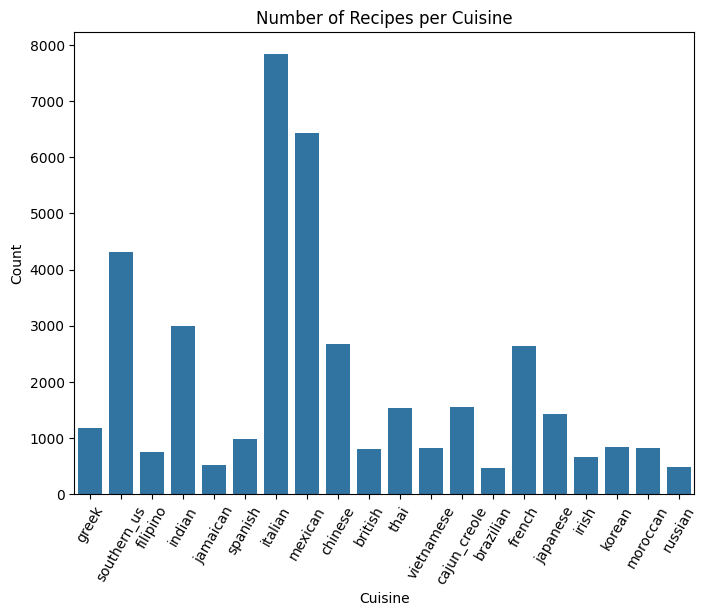

In [10]:
# Class distribution 
plt.figure(figsize=(8,6))
sns.countplot(data= train_df, x= 'cuisine')
plt.title("Number of Recipes per Cuisine")
plt.xlabel("Cuisine")
plt.ylabel("Count")
plt.xticks(rotation = 60)
plt.show()

### 1.3.5 Word Clouds of the Most Frequent Ingredients by Cuisine

In [11]:
# For each cuisine, combine all ingredients into one large text string
cuisine_texts = (
    train_df.groupby("cuisine")["ingredients"]
    .apply(lambda lists: " ".join([ing.replace(" ", "_") for lst in lists for ing in lst]))  
)

Replacing spaces with underscores, like `soy sauce` -> `soy_sauce`, prevents 'soy' and 'sauce' from being split apart, which ensures that multi-word ingredients are treated as single.

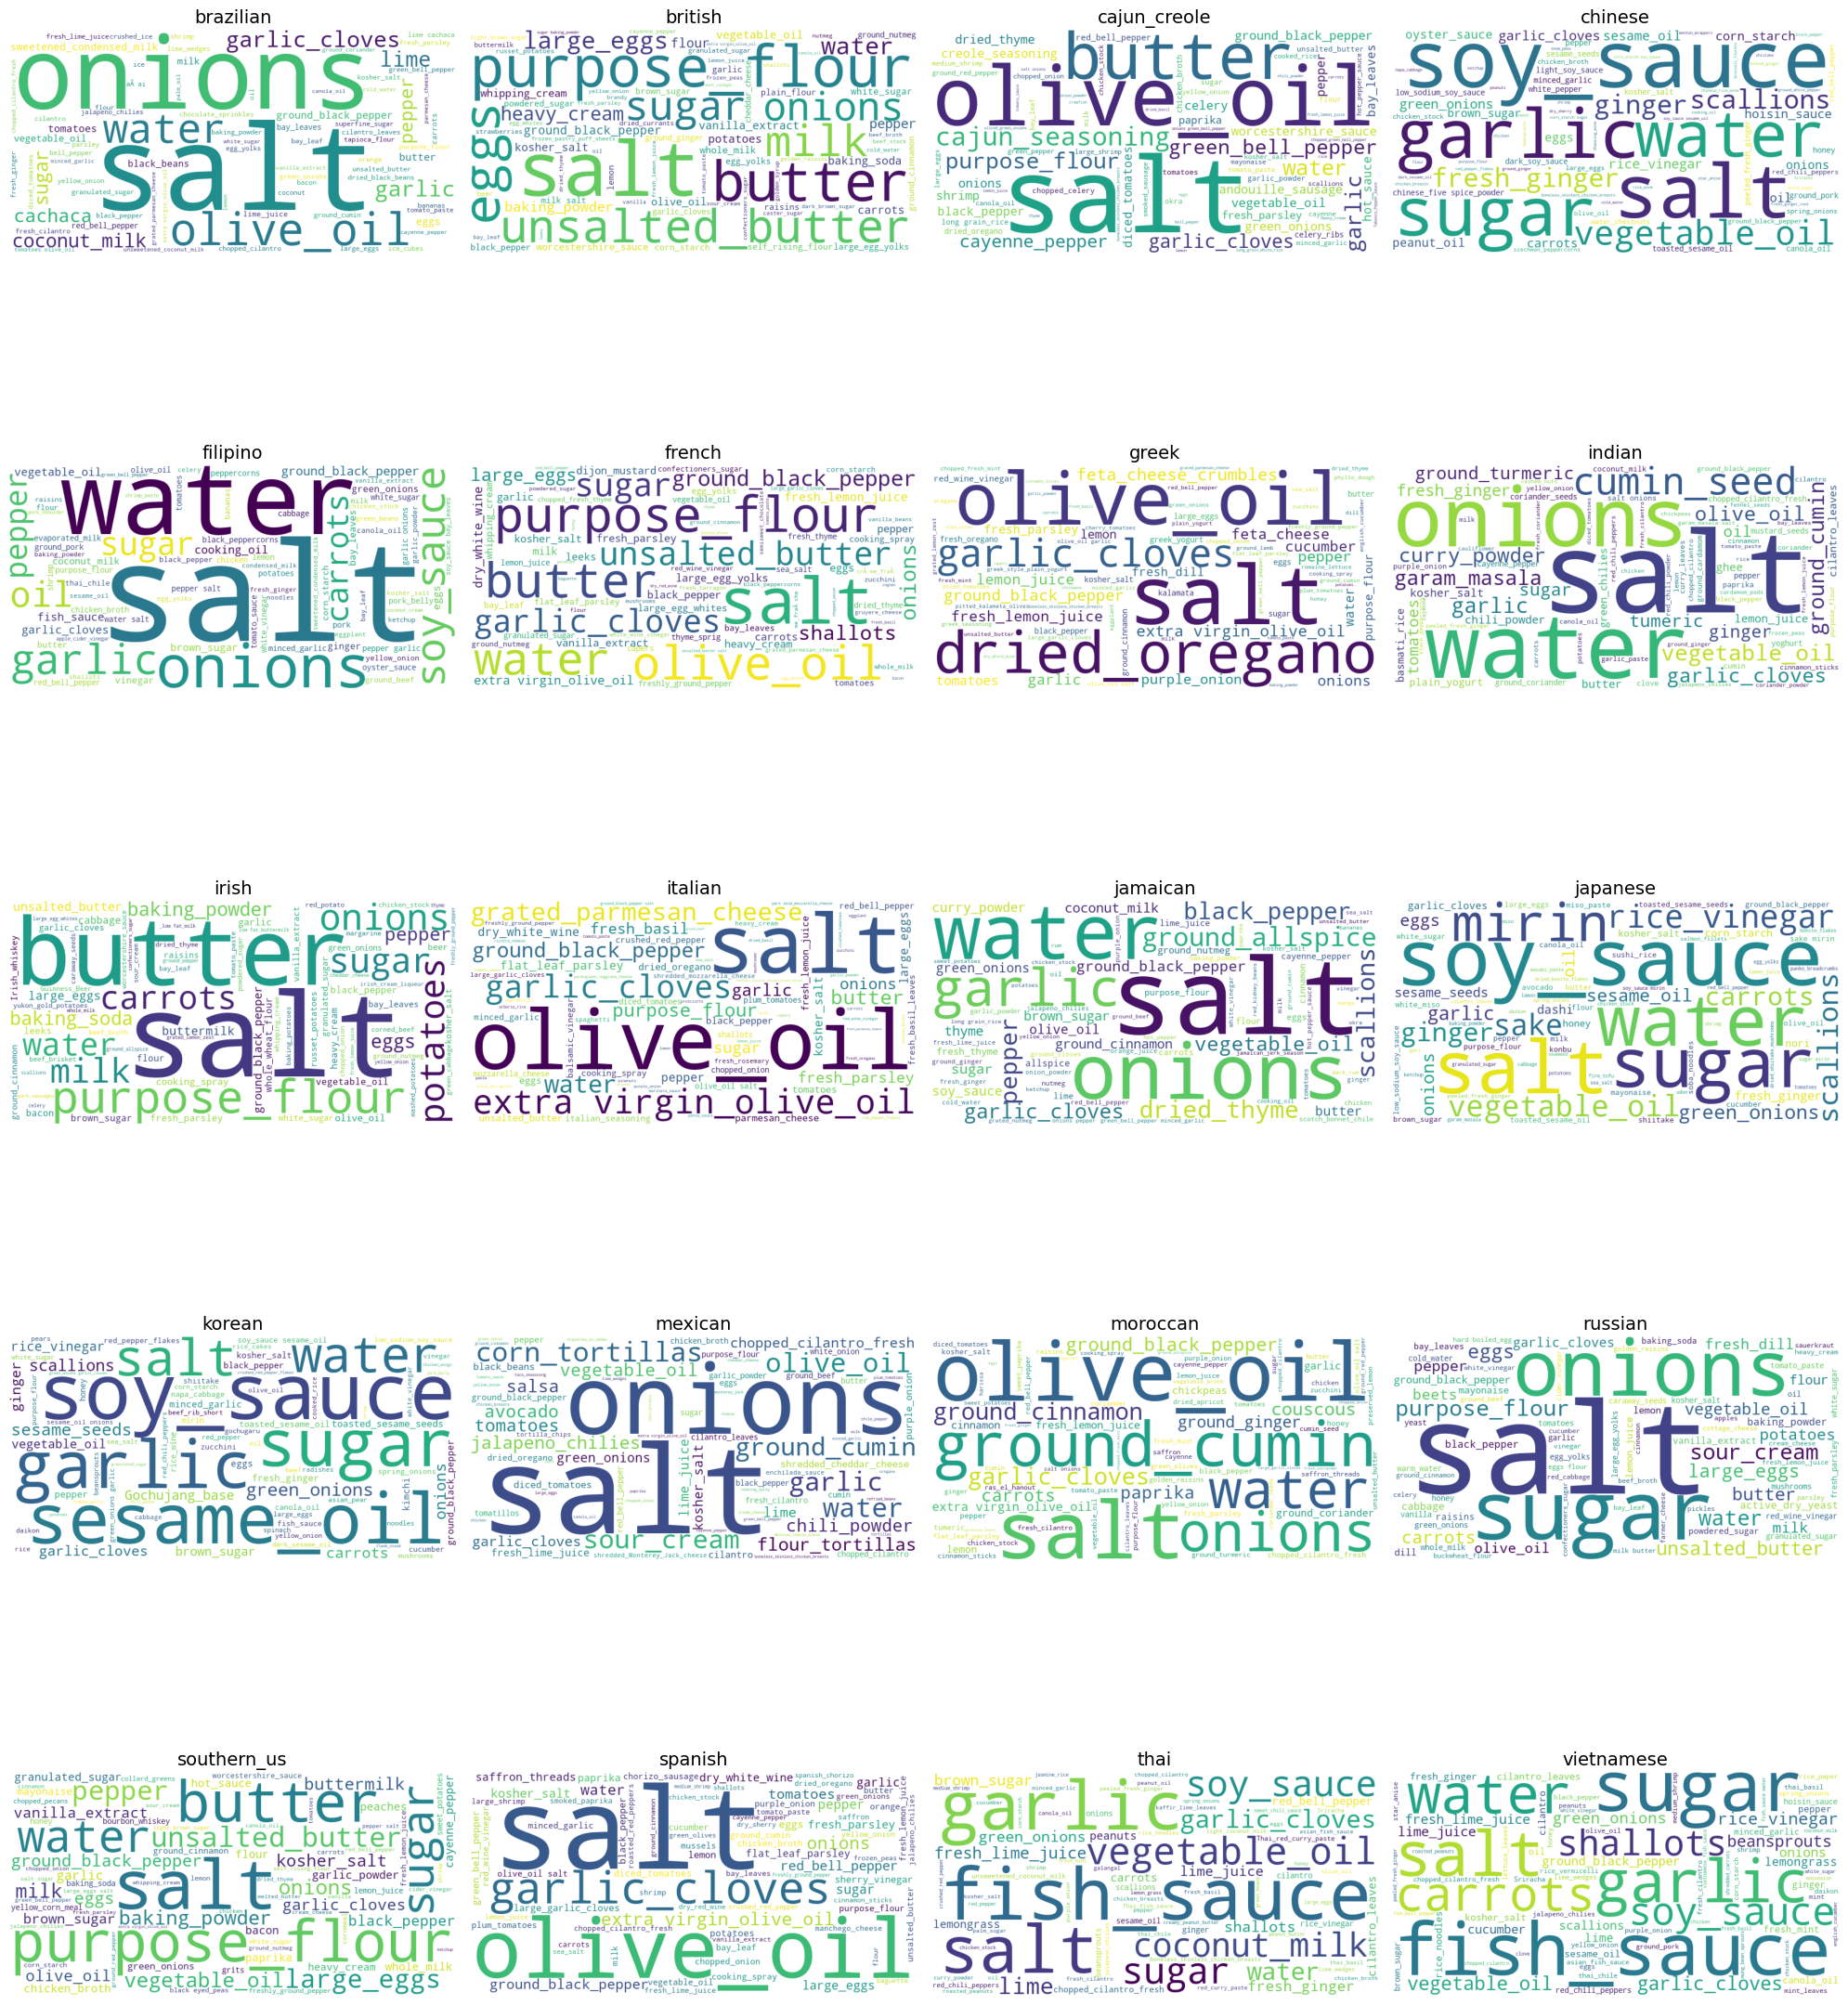

In [12]:
# Get list of cuisine names from the index
cuisines = cuisine_texts.index.tolist()

# Define grid layout for subplots
cols = 4
rows = 5

# Create the overall figure
plt.figure(figsize=(20, rows * 5))

# Loop over each cuisine and create a word cloud
for i, cuisine in enumerate(cuisines):
    plt.subplot(rows, cols, i + 1)  # Create subplot for each cuisine
    
    text = cuisine_texts[cuisine]  # Aggregate text for the current cuisine
    
    # Generate word cloud
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        max_words=80
    ).generate(text)
    
    # Display word cloud
    plt.imshow(wc)
    plt.axis("off")
    plt.title(cuisine, fontsize=14)

# Adjust spacing between plots
plt.tight_layout()
plt.show()

The word cloud analysis reveals that each cuisine has a distinctive set of ingredients that strongly differentiates it from others. For example, Korean cuisine prominently features ingredients such as sesame_oil, while Vietnamese cuisine frequently includes fish_sauce. Indian cuisine consistently shows combinations like onions and cumin_seed. These ingredient patterns are highly specific to each cuisine and rarely overlap across categories.
Because these ingredients create unique signatures for each cuisine, the dataset appears to be naturally separable. This suggests that even simple linear classifiers, such as Logistic Regression with TF-IDF features, should be capable of achieving strong performance. However, this remains an initial hypothesis based on the EDA. In the modeling section, we will test whether our assumption holds by evaluating performance across both the classical model and the neural network model.

## 1.4 Create Clean Text Column


As the first stage of data preprocessing, we transform the ingredient list into a single, cohesive text string. This is followed by text standardization: converting all characters to lowercase and using regular expressions to remove all punctuation, symbols, and extraneous whitespace to ensure a consistent format for downstream models.

In [15]:
def clean_text(ingredients):
    # join list into a string
    text = " ".join(ingredients)
    
    # lowercase
    text = text.lower()
    
    # remove punctuation
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    
    # collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

# Clean training set
train_df["text"] = train_df["ingredients"].apply(clean_text)

# Clean test set 
test_df["text"] = test_df["ingredients"].apply(clean_text)


## 1.5 Train/Validation Split

We introduced a separate validation set because we experimented with many different model structures, particularly during the neural network development phase, and repeatedly evaluating performance on the Kaggle test set was impractical. The validation set also allowed us to compare all models fairly under identical data conditions.

- We use stratification so each cuisine appears in both splits with same proportional amounts.

In [16]:
X = train_df["text"] # Clean text we created
y = train_df["cuisine"] # Labels

x_train, x_val, y_train, y_val = train_test_split(
    X, y,
    random_state = 42,
    test_size = 0.2,
    stratify = y
    )

print("Train Size:", x_train.shape)
print("Validation Size:", x_val.shape)



Train Size: (31819,)
Validation Size: (7955,)


## 1.6 Preprocessing for Logistic Regression 

Before starting the project, We planned to benchmark two distinct classification approaches: a classical machine learning (ML) model and a basic Neural Network (NN), aligning with the course's structure. I selected Logistic Regression for the classical method because the high dimensionality resulting from tokenization would be computationally challenging for non-linear methods like Random Forest. Furthermore, the distinct ingredient patterns observed in the word clouds suggest the data may be linearly separable, making Logistic Regression a strong initial baseline. The Neural Network will serve to capture any non-linear relationships and more complex feature interactions, requiring a separate preprocessing pipeline tailored for its architecture.

### 1.6.1 Build, Fit, and Transform the TF-IDF Vectorizer

#### Text Vectorization Choice: Why TF–IDF Instead of One-Hot Encoding?

To apply **Logistic Regression**, we must convert the ingredient text into numerical features.  
A simple option would be **one-hot encoding**, where each ingredient becomes a binary feature (1 = present, 0 = absent).  
However, one-hot encoding is too limited for text data and ignores several important properties of language.

Instead, we use **TF–IDF (Term Frequency–Inverse Document Frequency)**, which provides a richer and more informative representation.

---

#### What TF–IDF Does

For each term \( t \) (ingredient) in a document \( d \) (recipe), TF–IDF computes:


$$
\text{TF–IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$$


- **TF (Term Frequency)**: how often the ingredient appears in a given recipe  
- **IDF (Inverse Document Frequency)**: how rare or informative the ingredient is across all recipes in the dataset

---

#### Advantage 1: Meaningful Weights (vs. 0/1 in One-Hot)

With one-hot encoding, each ingredient is just:

- 0 = absent  
- 1 = present  

All ingredients are treated equally.

With **TF–IDF**, informative ingredients get **higher weights**, and very common ingredients get **lower weights**:

- Ingredients like `soy sauce`, `fish sauce`, `basil`, `garam masala`  
  → often associated with specific cuisines  
  → receive **higher TF–IDF weights**

- Ingredients like `salt`, `water`, `oil`  
  → appear in almost every recipe  
  → receive **very low TF–IDF weights**  

This helps the model focus on **cuisine-specific signals** rather than generic ingredients.

---

#### Advantage 2: Better Handling of Rare but Informative Ingredients

TF–IDF naturally emphasizes ingredients that:

- are **rare globally**, but  
- occur consistently in certain cuisines.

For example:

- `fish sauce` might be rare in the overall dataset,  
  but appears often in **Thai** and **Vietnamese** recipes.  

This makes those cuisines easier to distinguish, even if they have fewer samples.  
(Strictly speaking, TF–IDF does not "fix" class imbalance, but it helps the model notice distinctive patterns in minority classes.)

**Note:** Manning et al. (2008) recommend bigrams for text classification and note that trigrams generally do not improve performance due to sparsity.

---

#### Advantage 3: Support for n-grams (Important for Multi-Word Ingredients)

We configure TF–IDF with:
```python
ngram_range = (1, 2)
```
This means it uses:

- unigrams: `soy`, `ginger`, `basil`

- bigrams: `soy sauce`, `olive oil`, `fish sauce`

Many ingredients are multi-word phrases, and their meaning depends on the combination (e.g., soy sauce is not just soy + sauce).
TF–IDF with n-grams captures this structure automatically, while simple one-hot encoding cannot.

---

#### Advantage 4: Noise Reduction via Normalization and Regularization

Even though TF–IDF can generate some rare or noisy n-grams, its impact is limited because:

**TF–IDF normalization (L2)** scales each document vector so that no single term dominates.

**Logistic Regression with L2 regularization** further shrinks the coefficients of uninformative or rare features towards zero.

As a result, the model focuses on **consistent**, **predictive ingredients** (e.g., soy sauce, olive oil, turmeric) and effectively ignores random or noisy bigrams.


In [107]:
tfidf = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1, 2),   # unigrams + bigrams
    min_df=3,             # ignore words in fewer than 3 recipes
    strip_accents="unicode", # Treats "jalapeño" and "jalapeno" as the same ingredient
    norm='l2' # L2 normalization 
)

In [159]:
# Fit and Transform TF-IDF 
x_train_tfidf = tfidf.fit_transform(x_train)
x_val_tfidf   = tfidf.transform(x_val)

((31819, 23593), (7955, 23593), (9944, 23593))

## 1.7 Preprocessing for Neural Network

### 1.7.1 Tokenization Choice
For the neural network model, we convert each recipe’s ingredient text into integer sequences using **Keras’s word-based Tokenizer**. Each unique word is assigned an index, e.g.: `soy sauce garlic` → [57, 129, 305]

Although other tokenization strategies exist (character-level, subword), **word-based tokenization is the most appropriate choice** for our neural network preprocessing, based on what we observed in the EDA section:

- **Ingredients are meaningful at the word level.**  
  Each ingredient (e.g., *"soy sauce"*, *"olive oil"*, *"garam masala"*) is already a clean, well-defined word or phrase. Word-level tokens preserve this structure naturally.

- **Character-level tokenization breaks meaning apart** and produces unnecessarily long sequences.  
  For example, `soy sauce` becomes 10 separate character tokens, which provides no added value for ingredient classification in this problem.

- **Subword tokenization adds unnecessary complexity.**  
  Subword models (BPE, WordPiece) are helpful for very large or noisy vocabularies, but our vocabulary is relatively small and clean, so subword splitting offers no clear benefit.

- **Word-level tokens work well with the embedding layer**, and a vocabulary size of around 15,000 words is appropriate for this dataset. . We also experimented with larger vocabularies; however, no further performance improvement was observed.  



In [10]:
MAX_VOCAB = 15000

tokenizer = Tokenizer(
    num_words=MAX_VOCAB, 
    lower=True, 
    split=' '
)

# Fit only on training text (avoids data leakage)
tokenizer.fit_on_texts(x_train)

### 1.7.2 Convert Text into Sequence

In [11]:
# convert text into sequence (integer encoding)
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(test_df["text"])


### 1.7.3 Pad sequences 

We use a maximum sequence length of 40 to keep the network efficient while still capturing all meaningful ingredients in each recipe. Most recipes contain far fewer than 40 ingredients, so this length is sufficient to represent the data without making the model unnecessarily large. We also experimented with longer sequence lengths (e.g., 60) and with using the maximum natural sequence length from the dataset, but neither approach improved validation performance.

In [12]:
# make all sequences same length
MAX_LEN = 40

# I chose padding='post' because it is a more natural and readable choice for us.
x_train_pad = pad_sequences(x_train_seq, maxlen=MAX_LEN, padding='post') 
x_val_pad   = pad_sequences(x_val_seq, maxlen=MAX_LEN, padding='post')
x_test_pad = pad_sequences(x_test_seq,  maxlen=MAX_LEN, padding='post')

# Check Shapes
x_train_pad.shape, x_val_pad.shape, x_test_pad.shape



((31819, 40), (7955, 40), (9944, 40))

### 1.7.4 Prepare labels (integer encode cuisines)

In [13]:
# Neural networks need numeric labels:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)

# 2. Modelling

## 2.1 Logistic Regression with TF-IDF 
Our motivation for selecting Logistic Regression and TF-IDF as the baseline models is fully detailed in Sections 1.6 and 1.6.1, and is omitted here to avoid repetition.

We use multinomial Logistic Regression with L2 regularization (the default in scikit-learn). Because TF–IDF can assign very high weights to extremely rare ingredients, some features may appear highly informative even though they occur in only a few recipes. L2 regularization prevents the model from overfitting to these rare or noisy features by shrinking their coefficients toward zero. This helps the model focus on the more consistently informative ingredients and improves its ability to generalize to unseen recipes.


In [441]:
# Define search space for the regularization strength (Ridge = L2)
param_grid = {
    "C": [1, 3, 5, 7, 10]   # Tested range selected after initial trial
}

# Initialize Logistic Regression (L2 by default)
lr = LogisticRegression(
    max_iter=2000,        # Ensure convergence for high-dimensional TF–IDF features
    #class_weight='balanced',  # Not used due to lower validation accuracy
    n_jobs=-1             # Use all CPU cores
)

# Set up GridSearch with 5-fold cross-validation
grid = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring="accuracy",   # Optimize based on accuracy
    cv=5,                 # 5-fold CV
    n_jobs=-1,            # Parallelize search
    verbose=2             # Show progress
)

# Run the hyperparameter search
grid.fit(x_train_tfidf, y_train)

# Retrieve best hyperparameter and model
print("Best C:", grid.best_params_["C"])
print("Best CV score:", grid.best_score_)
best_lr = grid.best_estimator_


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best C: 5
Best CV score: 0.7820486039804483


### 2.1.1 Evaluation

In [399]:
y_pred_lr = best_lr.predict(x_val_tfidf)
accuracy_lr = accuracy_score(y_val, y_pred_lr)

print("Validation Accuracy:", accuracy_lr)
print(classification_report(y_val, y_pred_lr))

Validation Accuracy: 0.7822752985543683
              precision    recall  f1-score   support

   brazilian       0.79      0.60      0.68        93
     british       0.56      0.43      0.49       161
cajun_creole       0.80      0.71      0.75       309
     chinese       0.80      0.85      0.82       535
    filipino       0.72      0.51      0.60       151
      french       0.57      0.63      0.60       529
       greek       0.78      0.68      0.72       235
      indian       0.87      0.91      0.89       601
       irish       0.65      0.44      0.53       133
     italian       0.81      0.88      0.84      1568
    jamaican       0.87      0.73      0.79       105
    japanese       0.78      0.71      0.75       284
      korean       0.82      0.73      0.77       166
     mexican       0.88      0.92      0.90      1288
    moroccan       0.83      0.72      0.77       164
     russian       0.66      0.34      0.45        98
 southern_us       0.71      0.81      0.

The logistic regression model achieved an accuracy of approximately 77% on the validation set when trained with `class_weight="balanced"`. When I removed class weighting, the accuracy increased to about 78%. This is expected, because the dataset is only mildly imbalanced. Large classes such as Italian and Mexican contain over 6,000–8,000 training samples, while smaller classes like Russian, Brazilian, and Jamaican have fewer than 1,000 samples. 

Using `class_weight="balanced"` helps improve recall for these minority classes, since the model is encouraged to pay relatively more attention to them. However, this often comes at the cost of slightly lower overall accuracy, because adjusting class weights can distort the decision boundaries learned from the more common classes.

One important point is that we do not yet know the class distribution in the Kaggle test set. If the test set is also imbalanced, balanced class weights may help; if it is close to uniform, removing class weights may yield better accuracy. For now, I decided to keep the version that does not use `class_weight='balanced'`, because I expect the test set to have a similar class distribution as the training set, and overall accuracy is the main goal of this project.


### 2.1.2 Retrain the model on the entire training set

In [442]:
# Combine training and validation text
x_full = pd.concat([x_train, x_val], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)

# re-fit TF-IDF on all labeld data
tfidf_full = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1, 2),
    min_df=3,             # ignore words in fewer than 3 recipes
    strip_accents="unicode", # Treats "jalapeño" and "jalapeno" as the same ingredient
    norm='l2' # L2 normalization
)

X_full_tfidf = tfidf_full.fit_transform(x_full)

# Fit Logistic Regression with best C
final_lr = LogisticRegression(
    max_iter=2000,
    C=grid.best_params_["C"], # from GridSearchCV 
    n_jobs=-1
)

final_lr.fit(X_full_tfidf, y_full)

LogisticRegression(C=5, max_iter=2000, n_jobs=-1)

### 2.1.3 Predict cuisines with the tuned model 

In [404]:
x_test_tfidf = tfidf_full.transform(test_df["text"])
test_pred = final_lr.predict(x_test_tfidf)

# Build submission for kaggle
submission = pd.DataFrame({
    "id": test_df["id"],
    "cuisine": test_pred
})
submission.to_csv("submission_lr_v1.csv", index=False)

## 2.2 Neural Network Model


### 2.2.1 Build the model


***Embedding Layer:***
We included a trainable embedding layer and allowed it to learn representations directly from our dataset rather than using pretrained embeddings such as GloVe or Word2Vec. Pretrained embeddings are based on large general-purpose English corpora (e.g., Wikipedia, news text), which do not capture the domain-specific ingredient relationships that are important for this task. 

In the this dataset, ingredient words appear in highly characteristic combinations that correspond to particular cuisines. For example, words like "soy" and "sauce" frequently co-occur with "ginger" or "fish" in Vietnamese and Thai recipes, while "cumin" and "turmeric" often appear together in Indian cuisine. These patterns are unique to the cooking domain and are not reflected in general English embeddings. By training the embedding layer directly on our data, the model learns a representation space where ingredients belonging to the same cuisine naturally cluster together, improving classification performance.

We initially set the embedding dimension to 64 and later experimented with 128 dimensions. The validation performance did not improve noticeably when increasing the embedding size (accuracy = 77% for both), while a larger embedding increases both model complexity and computation time. Therefore, we continued with a 64-dimensional embedding as a more efficient choice without sacrificing predictive accuracy.




**Choice of Second Layer, Why GlobalAveragePooling1D:**
After the embedding layer, each recipe is represented as a 40×64 matrix, where each row corresponds to an ingredient and each column represents one dimension of the learned embedding space. To feed this representation into fully connected (Dense) layers, we must convert this matrix into a fixed-length vector. There are several ways to do this, including pooling operations (average or max), flattening, or applying sequence-processing layers such as Conv1D or RNNs.

Our first and most successful choice was **GlobalAveragePooling1D**. This layer computes the average of every embedding dimension across all tokens, effectively summarizing the entire recipe into a single, dense 64-dimensional vector. Conceptually, this gives us a stable representation of the overall "ingredient profile" of the recipe. Unlike max pooling, which selects only the strongest activation and can be sensitive to noise or rare ingredients, average pooling smooths across all ingredients and produced more reliable results in our experiments.

We evaluated several alternatives:

- **Flatten layer:** Collapsing the entire 40×64 embedding into a 2560-dimensional vector. This drastically increases the number of parameters and led to overfitting, resulting in a lower validation accuracy (~74%).
- **Conv1D + MaxPooling:** We experimented with Conv1D models using 64 and 128 filters, kernel sizes of 3 and 5, ReLU activations, and a GlobalMaxPooling1D layer. Although Conv1D can capture local ingredient combinations (similar to learned n-grams), the validation accuracy remained around 75%, below our GlobalAveragePooling1D baseline.
- **RNNs (LSTM/GRU):** Sequence models are useful when token order is important. However, in this dataset the order of ingredients does not carry meaningful information, so RNNs are not a natural fit and were not pursued further.

Across all experiments, **GlobalAveragePooling1D achieved the best balance of simplicity, stability, interpretability, and performance**, reaching approximately 77% validation accuracy. Therefore, we selected it as the second layer in our final neural network architecture.


**Dense Layer (128 Units)**
After the GlobalAveragePooling1D layer reduces each recipe to a 64-dimensional vector, we introduce a Dense layer with 128 units and a ReLU activation function. This layer serves as a non-linear feature transformation that allows the network to learn higher-level interactions between ingredients. The embedding layer captures semantic meaning for individual tokens, but a Dense layer is needed to combine these features in more complex ways that are useful for distinguishing between cuisines.

We experimented with different layer sizes and found that 128 units offered the best balance between model capacity and generalization. Smaller layers (32 or 64 units) tended to underfit, failing to capture richer ingredient interactions, while larger layers (256 units or more) did not improve validation accuracy and increased the risk of overfitting and longer training times. The 128-unit layer consistently produced strong performance and remained computationally efficient, making it a suitable choice for this task.


**Trying more layers:**
We also experimented with adding an additional dense layer using various sizes (64, 128, and 256 neurons). However, in every case, the validation accuracy decreased compared to the single-dense-layer model. The best single-layer model achieved 77% validation accuracy, whereas the two-layer architectures consistently dropped to around 75%.

In [14]:
EMBED_DIM = 64
num_classes = len(le.classes_)

model = models.Sequential([
    # Learnable ingredient embeddings
    layers.Embedding(
        input_dim=MAX_VOCAB,   # size of vocabulary
        output_dim=EMBED_DIM,  # embedding vector dimension
    ),

    # Compress variable-length sequences into a single vector
    layers.GlobalAveragePooling1D(),

    # Hidden layer for non-linear feature learning
    layers.Dense(128, activation='relu'),

    # Output layer: one probability per cuisine class
    layers.Dense(num_classes, activation='softmax')
])

# Compile model with standard multi-class classification settings
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


### 2.2.2 Train the mdoel

During training, we observed that after a certain number of epochs the validation accuracy began to decrease while training accuracy continued to improve, indicating overfitting. To address this, we used an `EarlyStopping` callback that monitors validation accuracy and restores the model weights from the epoch with the best validation performance.


In [409]:
early_stop = EarlyStopping(
    monitor='val_accuracy',      # track validation accuracy
    patience=20,                  # how many epochs to wait after last improvement
    restore_best_weights=True    # finf the best fit
)

# Fit the model
history = model.fit(
    x_train_pad,
    y_train_enc,
    validation_data=(x_val_pad, y_val_enc),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3813 - loss: 2.1705 - val_accuracy: 0.5551 - val_loss: 1.5224
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6116 - loss: 1.2990 - val_accuracy: 0.6476 - val_loss: 1.1757
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6721 - loss: 1.0764 - val_accuracy: 0.6738 - val_loss: 1.0532
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7033 - loss: 0.9696 - val_accuracy: 0.7058 - val_loss: 0.9898
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7290 - loss: 0.8934 - val_accuracy: 0.7192 - val_loss: 0.9309
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7483 - loss: 0.8363 - val_accuracy: 0.7292 - val_loss: 0.8901
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7599 - loss: 0.7929 - val_accuracy: 0.7370 - val_loss: 0.8768
Epoch 8/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7713 - loss: 0.7581 - val_accu

### 2.2.3 Identifying the Best Epoch Based on Validation Accuracy

In [410]:
val_acc = history.history['val_accuracy']
best_epoch = np.argmax(val_acc)
best_val_acc = val_acc[best_epoch]

print("Best epoch:", best_epoch + 1)   # +1 because epochs start at 1
print("Best val accuracy:", best_val_acc)

Best epoch: 31
Best val accuracy: 0.7743557691574097


### 2.2.4 Retrain the model on full data 
To obtain a stronger prediction on the Kaggle test set, we retrain the model on the full training data so that it can learn from as many examples as possible. To avoid overfitting during this process, we use the optimal number of epochs determined earlier from the validation-based training phase.

In [15]:
# Combine training and validation data
X_full_nn = np.concatenate([x_train_pad, x_val_pad], axis=0)
y_full_nn = np.concatenate([y_train_enc, y_val_enc], axis=0)

# Retrain on full data
history = model.fit(
    X_full_nn,
    y_full_nn,
    epochs=best_epoch + 1,   # learn from validation set 
    batch_size=128
)


Epoch 1/32
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4182 - loss: 2.0360
Epoch 2/32
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6279 - loss: 1.2401
Epoch 3/32
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6853 - loss: 1.0346
Epoch 4/32
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7182 - loss: 0.9279
Epoch 5/32
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7413 - loss: 0.8587
Epoch 6/32
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7564 - loss: 0.8072
Epoch 7/32
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7697 - loss: 0.7674
Epoch 8/32
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7801 - loss: 0.7318
Epoch 9/32
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7895 - loss: 0.7035
Epoch 10/32
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7973 - loss: 0.6788
Epoch 11/32
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8031 - loss: 0.6584
Epoch 12/32
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

### 2.2.5 Generating Predictions on the Test Set and Creating the Submission File

In [414]:
test_pred_int = model.predict(x_test_pad).argmax(axis=1)
test_pred_labels = le.inverse_transform(test_pred_int)


# Submission:
submission_nn = pd.DataFrame({
    "id": test_df["id"],
    "cuisine": test_pred_labels
})
submission_nn.to_csv("submission_nn_fulldata.csv", index=False)

311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


# 3. New Cleaning Strategy: Preserving Multi-Word Ingredients as Single Tokens

In our initial preprocessing approach, we merged all ingredients into a single text string and then applied standard text tokenization and TF-IDF. While this allowed us to use classical NLP feature-engineering techniques, it introduced an important concern: multi-word ingredients such as "soy sauce" or "fish sauce" were split into independent tokens. As a result, the model treated "soy" and "sauce" as separate words, even though they represent a single meaningful ingredient when combined.

To address this limitation, we introduce an alternative cleaning strategy designed to preserve the original ingredient structure from the raw dataset. Since each ingredient is already provided as a distinct token, we replace spaces within multi-word ingredients with underscores (e.g., "soy sauce" → "soy_sauce"). This ensures that each ingredient remains intact during tokenization and feature extraction.

Using this improved representation, we re-evaluate our two models to examine whether this change in preprocessing affects their performance:

**Logistic Regression** (TF-IDF Features)

We continue using TF-IDF for feature extraction, but now apply it to the cleaned ingredient strings in which each ingredient appears as a single token. This prevents multi-word ingredients from being unintentionally split, resulting in a feature representation that more closely matches the structure of the original dataset. We then evaluate whether this modified representation leads to any performance differences compared to the earlier approach.

**Neural Network** (Learned Ingredient Embeddings)

For the neural network, the cleaned ingredient tokens are used directly to train a learnable embedding layer. This representation preserves ingredient-level structure and allows the network to learn relationships between ingredients without fragmentation. As with logistic regression, our goal is to assess whether this preprocessing change improves, worsens, or does not materially affect the model's predictive performance.

## 3.1 Clean and Normalize Ingredients (Preserve Multi-Word Tokens)

In [13]:
def clean_and_normalize_ingredient(ing):
    # lowercase
    ing = ing.lower()
    
    # replace symbols with space (keeps letters)
    ing = re.sub(r"[^a-zA-Z\s]", " ", ing)
    
    # collapse multiple spaces
    ing = re.sub(r"\s+", " ", ing)
    
    # strip leading/trailing spaces
    ing = ing.strip()
    
    # replace spaces with underscores to keep multi-word ingredient as a single token
    ing = ing.replace(" ", "_")
    
    return ing

def clean_ingredient_list(lst):
    return [clean_and_normalize_ingredient(ing) for ing in lst]


# Apply to datasets
train_df["ingredients_clean_2"] = train_df["ingredients"].apply(clean_ingredient_list)
test_df ["ingredients_clean_2"] = test_df["ingredients"].apply(clean_ingredient_list)

# We convert each ingredient list into a single space-separated string where each ingredient is now a single token.
# Join cleaned list into a single string for TF-IDF
train_df["ingredients_text_2"] = train_df["ingredients_clean_2"].apply(lambda x: " ".join(x))
test_df["ingredients_text_2"] = test_df["ingredients_clean_2"].apply(lambda x: " ".join(x))

# Preview
train_df["ingredients_text_2"].head()

0    romaine_lettuce black_olives grape_tomatoes ga...
1    plain_flour ground_pepper salt tomatoes ground...
2    eggs pepper salt mayonaise cooking_oil green_c...
3                       water vegetable_oil wheat salt
4    black_pepper shallots cornflour cayenne_pepper...
Name: ingredients_text_2, dtype: object

## 3.2 Train/Validation Split

In [17]:
X_2 = train_df["ingredients_text_2"]
y_2 = train_df["cuisine"]


x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(
    X_2, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


print("Train Size:", x_train.shape)
print("Validation Size:", x_val.shape)

Train Size: (31819,)
Validation Size: (7955,)


## 3.3 Preprocessing for Logistic Regression
### 3.3.1 Prepare TF-IDF Features for Logistic Regression

In [18]:
tfidf_2 = TfidfVectorizer(
    token_pattern=r"(?u)\b\w+\b",  # ensures tokens like soy_sauce stay intact
    ngram_range=(1,1),
    min_df=3,
    norm='l2' # L2 normalization
)

x_train_tfidf_2 = tfidf_2.fit_transform(x_train_2)
x_val_tfidf_2 = tfidf_2.transform(x_val_2)

## 3.4 Preprocessing for Neural Network

### 3.4.1 Tokenization

In [19]:
tokenizer_2 = Tokenizer(
    lower=True, 
    split=' '
)

# Fit only on training text (avoids data leakage)
tokenizer_2.fit_on_texts(x_train_2)

### 3.4.2 Convert text into sequence

In [419]:
# convert text into sequence (integer encoding)
x_train_seq_2 = tokenizer_2.texts_to_sequences(x_train_2)
x_val_seq_2 = tokenizer_2.texts_to_sequences(x_val_2)
x_test_seq_2 = tokenizer_2.texts_to_sequences(test_df["ingredients_text_2"])

### 3.4.3 Pad Sequences

In [420]:
# I chose padding='post' because it is a more natural and readable choice for us.
MAX_LEN_2 = 40
x_train_pad_2 = pad_sequences(x_train_seq_2, maxlen=MAX_LEN_2, padding='post') 
x_val_pad_2 = pad_sequences(x_val_seq_2, maxlen=MAX_LEN_2, padding='post')
x_test_pad_2 = pad_sequences(x_test_seq_2, maxlen=MAX_LEN_2, padding='post')

# Check Shapes
x_train_pad_2.shape, x_val_pad_2.shape, x_test_pad_2.shape

((31819, 40), (7955, 40), (9944, 40))

### 3.4.4 Prepare labels (integer encode cuisines)

In [421]:
# Neural networks need numeric labels:
le_2 = LabelEncoder()
y_train_enc_2 = le_2.fit_transform(y_train_2)
y_val_enc_2   = le_2.transform(y_val_2)

## 3.5 Models

### 3.5.1 Logistic Regression 
#### Fit the Model

In [20]:
param_grid_2 = {
    "C": [1, 2, 3, 4, 5]
}

lr_2 = LogisticRegression(
    max_iter=2000,
    #class_weight='balanced',
    n_jobs=-1
)

grid_2 = GridSearchCV(
    estimator=lr_2,
    param_grid=param_grid_2,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_2.fit(x_train_tfidf_2, y_train_2)

print("Best C:", grid_2.best_params_["C"])
print("Best CV score:", grid_2.best_score_)
best_lr_2= grid_2.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best C: 3
Best CV score: 0.7791256372651721


#### Evaluation on Validation Set 

In [423]:
y_pred_lr_2 = best_lr_2.predict(x_val_tfidf_2)
accuracy_lr_2 = accuracy_score(y_val_2, y_pred_lr_2)

print("Validation Accuracy:", accuracy_lr_2)
print(classification_report(y_val_2, y_pred_lr_2))

Validation Accuracy: 0.7811439346323067
              precision    recall  f1-score   support

   brazilian       0.86      0.58      0.69        93
     british       0.60      0.47      0.53       161
cajun_creole       0.78      0.69      0.73       309
     chinese       0.80      0.85      0.82       535
    filipino       0.76      0.56      0.64       151
      french       0.57      0.63      0.60       529
       greek       0.79      0.66      0.72       235
      indian       0.87      0.91      0.89       601
       irish       0.71      0.46      0.56       133
     italian       0.80      0.89      0.84      1568
    jamaican       0.83      0.65      0.73       105
    japanese       0.79      0.73      0.75       284
      korean       0.84      0.74      0.79       166
     mexican       0.89      0.91      0.90      1288
    moroccan       0.84      0.73      0.78       164
     russian       0.69      0.38      0.49        98
 southern_us       0.71      0.80      0.

#### Retrain the model on the entire training set

In [428]:
# Combine training and validation text
x_full_2 = pd.concat([x_train_2, x_val_2], axis=0)
y_full_2= pd.concat([y_train_2, y_val_2], axis=0)

# re-fit TF-IDF on all labeld data
tfidf_full_2 = TfidfVectorizer(
    token_pattern=r"(?u)\b\w+\b",  # ensures tokens like soy_sauce stay intact
    ngram_range=(1,1),
    min_df=3,
    norm='l2' # L2 normalization
)

X_full_tfidf_2 = tfidf_full_2.fit_transform(x_full_2)

# Fit Logistic Regression with best C
final_lr_2 = LogisticRegression(
    max_iter=2000,
    C=grid.best_params_["C"], # from GridSearchCV
    n_jobs=-1
)

final_lr_2.fit(X_full_tfidf_2, y_full_2)

LogisticRegression(C=5, max_iter=2000, n_jobs=-1)

#### Predict cuisines with the tuned model

In [429]:
x_test_tfidf_2 = tfidf_full_2.transform(test_df["ingredients_text_2"])
test_pred_2 = final_lr_2.predict(x_test_tfidf_2)

# Build submission for kaggle
submission = pd.DataFrame({
    "id": test_df["id"],
    "cuisine": test_pred_2
})
submission.to_csv("submission_lr_v2.csv", index=False)

### 3.5.2 Neural Network Model

#### Build the Model

In [438]:
EMBED_DIM_2 = 64
num_classes_2 = len(le_2.classes_)

model_2 = models.Sequential([
    # Learnable ingredient embeddings
    layers.Embedding(
        input_dim=len(tokenizer_2.word_index) + 1,   # size of vocabulary
        output_dim=EMBED_DIM_2,  # embedding vector dimension
    ),

    # Compress variable-length sequences into a single vector
    layers.GlobalAveragePooling1D(),

    # Hidden layer for non-linear feature learning
    layers.Dense(128, activation='relu'),

    # Output layer: one probability per cuisine class
    layers.Dense(num_classes_2, activation='softmax')
])

# Compile model with standard multi-class classification settings
model_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


#### Fit the Model 

In [431]:
early_stop_2 = EarlyStopping(
    monitor='val_accuracy',      # track validation accuracy
    patience=20,                  # how many epochs to wait after last improvement
    restore_best_weights=True    # finf the best fit
)

history_2 = model_2.fit(
    x_train_pad_2,
    y_train_enc_2,
    validation_data=(x_val_pad_2, y_val_enc_2),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop_2],
    verbose=1
)

Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3796 - loss: 2.1794 - val_accuracy: 0.5388 - val_loss: 1.5604
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 1.3307 - val_accuracy: 0.6358 - val_loss: 1.2085
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6665 - loss: 1.0976 - val_accuracy: 0.6759 - val_loss: 1.0696
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7052 - loss: 0.9754 - val_accuracy: 0.7043 - val_loss: 0.9773
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7299 - loss: 0.8940 - val_accuracy: 0.7217 - val_loss: 0.9326
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7489 - loss: 0.8368 - val_accuracy: 0.7335 - val_loss: 0.8861
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7610 - loss: 0.7947 - val_accuracy: 0.7447 - val_loss: 0.8787
Epoch 8/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7710 - loss: 0.7629 - val_accu

#### Identifying the Best Epoch Based on Validation Accuracy

In [432]:
val_acc_2 = history_2.history['val_accuracy']
best_epoch_2 = np.argmax(val_acc_2)
best_val_acc_2 = val_acc[best_epoch_2]

print("Best epoch:", best_epoch_2 + 1)   # +1 because epochs start at 1
print("Best val accuracy:", best_val_acc_2)

Best epoch: 26
Best val accuracy: 0.7742300629615784


#### Retrain the model on full data 

In [439]:
# Combine training and validation data
X_full_nn_2 = np.concatenate([x_train_pad_2, x_val_pad_2], axis=0)
y_full_nn_2 = np.concatenate([y_train_enc_2, y_val_enc_2], axis=0)

# Retrain on full data
history = model_2.fit(
    X_full_nn_2,
    y_full_nn_2,
    epochs=best_epoch_2 + 1,   # learn from validation set 
    batch_size=128
)

Epoch 1/26
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4064 - loss: 2.0469
Epoch 2/26
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6278 - loss: 1.2306
Epoch 3/26
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6879 - loss: 1.0279
Epoch 4/26
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7204 - loss: 0.9258
Epoch 5/26
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7396 - loss: 0.8608
Epoch 6/26
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7560 - loss: 0.8089
Epoch 7/26
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7685 - loss: 0.7699
Epoch 8/26
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7770 - loss: 0.7403
Epoch 9/26
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7859 - loss: 0.7126
Epoch 10/26
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7923 - loss: 0.6895
Epoch 11/26
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7990 - loss: 0.6690
Epoch 12/26
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

#### Generating Predictions on the Test Set and Creating the Submission File

In [440]:
test_pred_int_2 = model_2.predict(x_test_pad_2).argmax(axis=1)
test_pred_labels_2 = le_2.inverse_transform(test_pred_int_2)


# Submission:
submission_nn_2 = pd.DataFrame({
    "id": test_df["id"],
    "cuisine": test_pred_labels_2
})
submission_nn.to_csv("submission_nn_fulldata2.csv", index=False)

311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


## 4. Model Comparison and Final Model Selection

We evaluated multiple modeling approaches for the "What’s Cooking?" classification task, including both classical machine learning and neural network–based models. Two different tokenization strategies were also tested. Table 1 summarizes the validation accuracy and Kaggle leaderboard scores for each configuration.

### Table 1: Performance Comparison Across All Models
| Model | Tokenization Strategy | Validation Accuracy | Kaggle Test Accuracy |
|-------|------------------------|----------------------|------------------------|
| **TF–IDF + Logistic Regression** | Word-level (ingredients split into tokens) | **0.7822** | **0.7915** |
| Neural Network (Embedding + GlobalAvgPool) | Word-level | 0.7743 | 0.7754 |
| TF–IDF + Logistic Regression | Ingredient-level (using `soy_sauce`, `fish_sauce`, etc.) | 0.7791 | 0.7874 |
| Neural Network (Embedding + GlobalAvgPool) | Ingredient-level | 0.7742 | 0.7754 |

**Winner:** **TF–IDF + Logistic Regression (word-level tokenization)**  
This model achieved the highest validation accuracy (0.7822) and the strongest Kaggle public leaderboard score (0.7915).

---

### 4.1 Effect of Tokenization and Cleaning Strategy
We explored two tokenization approaches:

1. **Word-level tokenization:**  
   Each ingredient is split into individual words (e.g., `"soy sauce"` → `"soy"`, `"sauce"`).

2. **Ingredient-level tokenization:**  
   Multi-word ingredients are preserved as single tokens using underscores (e.g., `"soy_sauce"`).

Although ingredient-level tokens seemed intuitively promising, because "soy_sauce" represents a unique ingredient, the empirical results show **no improvement** in either classical or neural models. In fact, the best-performing configuration remained the word-level TF–IDF + Logistic Regression model.

This suggests that:  
- The TF–IDF representation already captures useful n-gram patterns (e.g., `"soy sauce"` as a bigram).  
- Underscore joining did not add meaningful signal for classification.  
- For neural networks, both tokenization schemes produced nearly identical performance.

---

### 4.2 Comparison of Classical ML vs Neural Network Models
The simple neural network (Embedding → GlobalAveragePooling → Dense(128) → Dropout → Softmax) achieved a validation accuracy around **77%** but did not outperform logistic regression.

Neural networks typically achieve their strongest performance when they have access to large datasets with rich hierarchical or nonlinear patterns. However, This dataset consists of very short documents, each recipe contains only a limited list of ingredients and minimal structural complexity. As a result, the neural network architecture cannot fully leverage the representational advantages of deep learning. In contrast, TF–IDF provides a highly effective representation for this problem. Because ingredient lists are sparse and composed of distinctive tokens, TF–IDF creates a high-dimensional feature space in which many cuisines become nearly linearly separable. Logistic regression performs particularly well in this setting, as the presence or absence of specific ingredients provides strong, direct signals that allow linear decision boundaries to classify the data accurately. Consequently, the classical TF–IDF + Logistic Regression model outperforms the neural network model, both on the validation set and on the Kaggle leaderboard.


---

### 4.3 Alternate Neural Architectures (Not Retained)
We also experimented with several other neural network structures:

- Conv1D with Max pooling (64, 128) (Kernel sizes 3 and 5)  
- GlobalMaxPooling1D  
- Flatten-based models  
- Deeper Dense layers  

As explained in Section 2.2.1, none of these variants improved validation accuracy. To maintain a clean and reproducible notebook, these architectures were removed and not evaluated on the Kaggle test set.

---

### 4.4 Final Model Selection
Based on both validation and test performance, we selected:

> **Final Model: TF–IDF + Logistic Regression (word-level tokenization)**  
> **Validation Accuracy: 0.7822**  
> **Kaggle Accuracy: 0.7915**

This model demonstrates the best generalization performance, is computationally efficient, interpretable, and robust to different tokenization strategies. It therefore serves as the final model for generating Kaggle submissions.


# Refrences:
Manning, C. D., Raghavan, P., & Schütze, H. (2008). Introduction to information retrieval. Cambridge University Press. 